In [1]:
#Loding Renewvable electicity installed capacity data set to panda library from csv files
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

spark = SparkSession.builder.appName("BDA-RenewableEnergy-Capacity").getOrCreate()
ecdata0_9 = pd.read_csv('./Datasets/ELECCAP_2000_2009.csv',encoding = "ISO-8859-1")
ecdata0_9 = ecdata0_9.replace('..',0)
ecdata10_19 = pd.read_csv('./Datasets/ELECCAP_2010_2019.csv',encoding = "ISO-8859-1")
ecdata10_19 = ecdata10_19.replace('..',0)
ecdata20 = pd.read_csv('./Datasets/ELECCAP_2020.csv',encoding = "ISO-8859-1")
ecdata20 = ecdata20.replace('..',0)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/07 12:44:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/07 12:44:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/07 12:44:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/05/07 12:44:59 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
#Merging three panda dataframe into one draframe
frames = [ecdata0_9, ecdata10_19, ecdata20]
finalECData = pd.concat(frames)
finalECData['Country'] = finalECData['Country'].astype(str)
finalECData['Technology'] = finalECData['Technology'].astype(str)
finalECData['Year'] = finalECData['Year'].astype(int)
finalECData['Installed_capacity_MW'] = finalECData['Installed_capacity_MW'].astype(float)
finalECData.sort_values('Installed_capacity_MW',ascending = False)

Country                  Technology      Grid  Year  \
1751                   China                Fossil fuels   On-grid  2020   
1761                   China         Fossil fuels n.e.s.   On-grid  2020   
17619                  China         Fossil fuels n.e.s.   On-grid  2019   
17519                  China                Fossil fuels   On-grid  2019   
17618                  China         Fossil fuels n.e.s.   On-grid  2018   
...                      ...                         ...       ...   ...   
70218  Saint Kitts and Nevis         Onshore wind energy   On-grid  2008   
70219  Saint Kitts and Nevis         Onshore wind energy   On-grid  2009   
70220  Saint Kitts and Nevis        Offshore wind energy  Off-grid  2000   
70221  Saint Kitts and Nevis        Offshore wind energy  Off-grid  2001   
9323                Zimbabwe  Other non-renewable energy   On-grid  2020   

       Installed_capacity_MW  
1751              1219693.00  
1761              1219693.00  
17619             1167024.15  
17519             1167024.15  
17618             1126270.00  
...                      ...  
70218                   0.00  
70219                   0.00  
70220                   0.00  
70221                   0.00  
9323                    0.00  

[195804 rows x 5 columns]

22/05/07 14:04:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 334102 ms exceeds timeout 120000 ms
22/05/07 14:04:46 WARN SparkContext: Killing executors is not supported by current scheduler.


In [5]:
#Converting Panda DF to Spark DF
from pyspark.sql import SparkSession
from pyspark.sql.types import *
df_schema = StructType([StructField("Country", StringType(), True),StructField("Technology", StringType(), True), StructField("Grid", StringType(), True), StructField("Year", IntegerType(), True),StructField("Installed_capacity_MW", FloatType(), False)])
sparkEnergyDF = spark.createDataFrame(finalECData, schema=df_schema)
sparkEnergyDF.show()

+-----------+--------------------+--------+----+---------------------+
|    Country|          Technology|    Grid|Year|Installed_capacity_MW|
+-----------+--------------------+--------+----+---------------------+
|Afghanistan|On-grid Solar pho...|Off-grid|2000|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2001|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2002|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2003|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2004|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2005|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2006|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2007|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2008|                  0.0|
|Afghanistan|On-grid Solar pho...|Off-grid|2009|                  0.0|
|Afghanistan|On-grid Solar pho...| On-grid|2000|                  0.0|
|Afgha

In [6]:
#Spark SQL 
#Convert MWh to GWh
#1 megawatt (MW) = 0.0010 gigawatts (GW)
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, timedelta, datetime, time

sparkEnergyDF.createOrReplaceTempView("sparkEnergyDF")
#Filter only Renewable Energy and store it in Spark DF
sparkFinalReEnergyDF = spark.sql('SELECT Country,Year,SUM(Installed_capacity_MW*0.0010) as Total_Installed_Capacity_GW FROM sparkEnergyDF WHERE Technology IN ("On-grid Solar photovoltai","Off-grid Solar photovoltaic","Concentrated solar power","Onshore wind energy","Offshore wind energy","Renewable hydropower","Mixed Hydro Plants","Pumped storage","Solid biofuels","Renewable municipal waste","Liquid biofuels","Biogas","Geothermal energy","Marine energy") GROUP BY Country,Year ORDER BY Total_Installed_Capacity_GW DESC')
sparkFinalReEnergyDF.show()

+--------------------+----+---------------------------+
|             Country|Year|Total_Installed_Capacity_GW|
+--------------------+----+---------------------------+
|               China|2020|          671.7691100769044|
|               China|2019|          584.9790301818846|
|               China|2018|          550.8481218566894|
|               China|2017|          519.8112212524413|
|               China|2016|          490.2756930541993|
|               China|2015|         458.95341009521485|
|               China|2014|          408.7105000925064|
|               China|2013|         363.59831976413733|
|               China|2012|          315.9335442228317|
|               China|2011|         283.35030996227266|
|               China|2010|         249.32296796512605|
|United States of ...|2020|         237.00629418945311|
|United States of ...|2019|         222.68949999999998|
|               China|2009|         218.64849765920638|
|United States of ...|2018|                     

In [7]:
sparkFinalReEnergy_PandaDF = sparkFinalReEnergyDF.toPandas()
totalTopInstCapRenew_PandaDF = sparkFinalReEnergy_PandaDF.sort_values('Total_Installed_Capacity_GW',ascending = False).groupby('Year').head(10).reset_index()
totalTopInstCapRenew_PandaDF

index  Country  Year  Total_Installed_Capacity_GW
0        0    China  2020                   671.769110
1        1    China  2019                   584.979030
2        2    China  2018                   550.848122
3        3    China  2017                   519.811221
4        4    China  2016                   490.275693
..     ...      ...   ...                          ...
205    253   France  2000                    25.837000
206    255  Germany  2003                    25.554000
207    266    Spain  2002                    23.375000
208    272    Italy  2001                    22.250000
209    275    Italy  2000                    21.840500

[210 rows x 4 columns]

Text(0.5, 1.0, 'Top countries who has high renewable energy plant installed capacity')

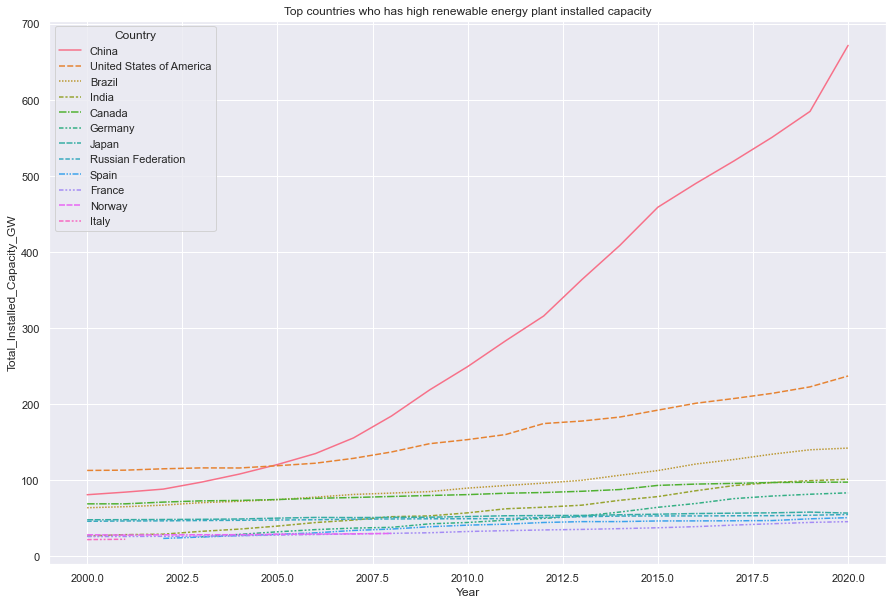

In [8]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set(rc={'figure.figsize':(15,10)})
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Total_Installed_Capacity_GW",
             hue="Country", style="Country",sizes=(100, 300),
             data=totalTopInstCapRenew_PandaDF).set_title('Top countries who has high renewable energy plant installed capacity')

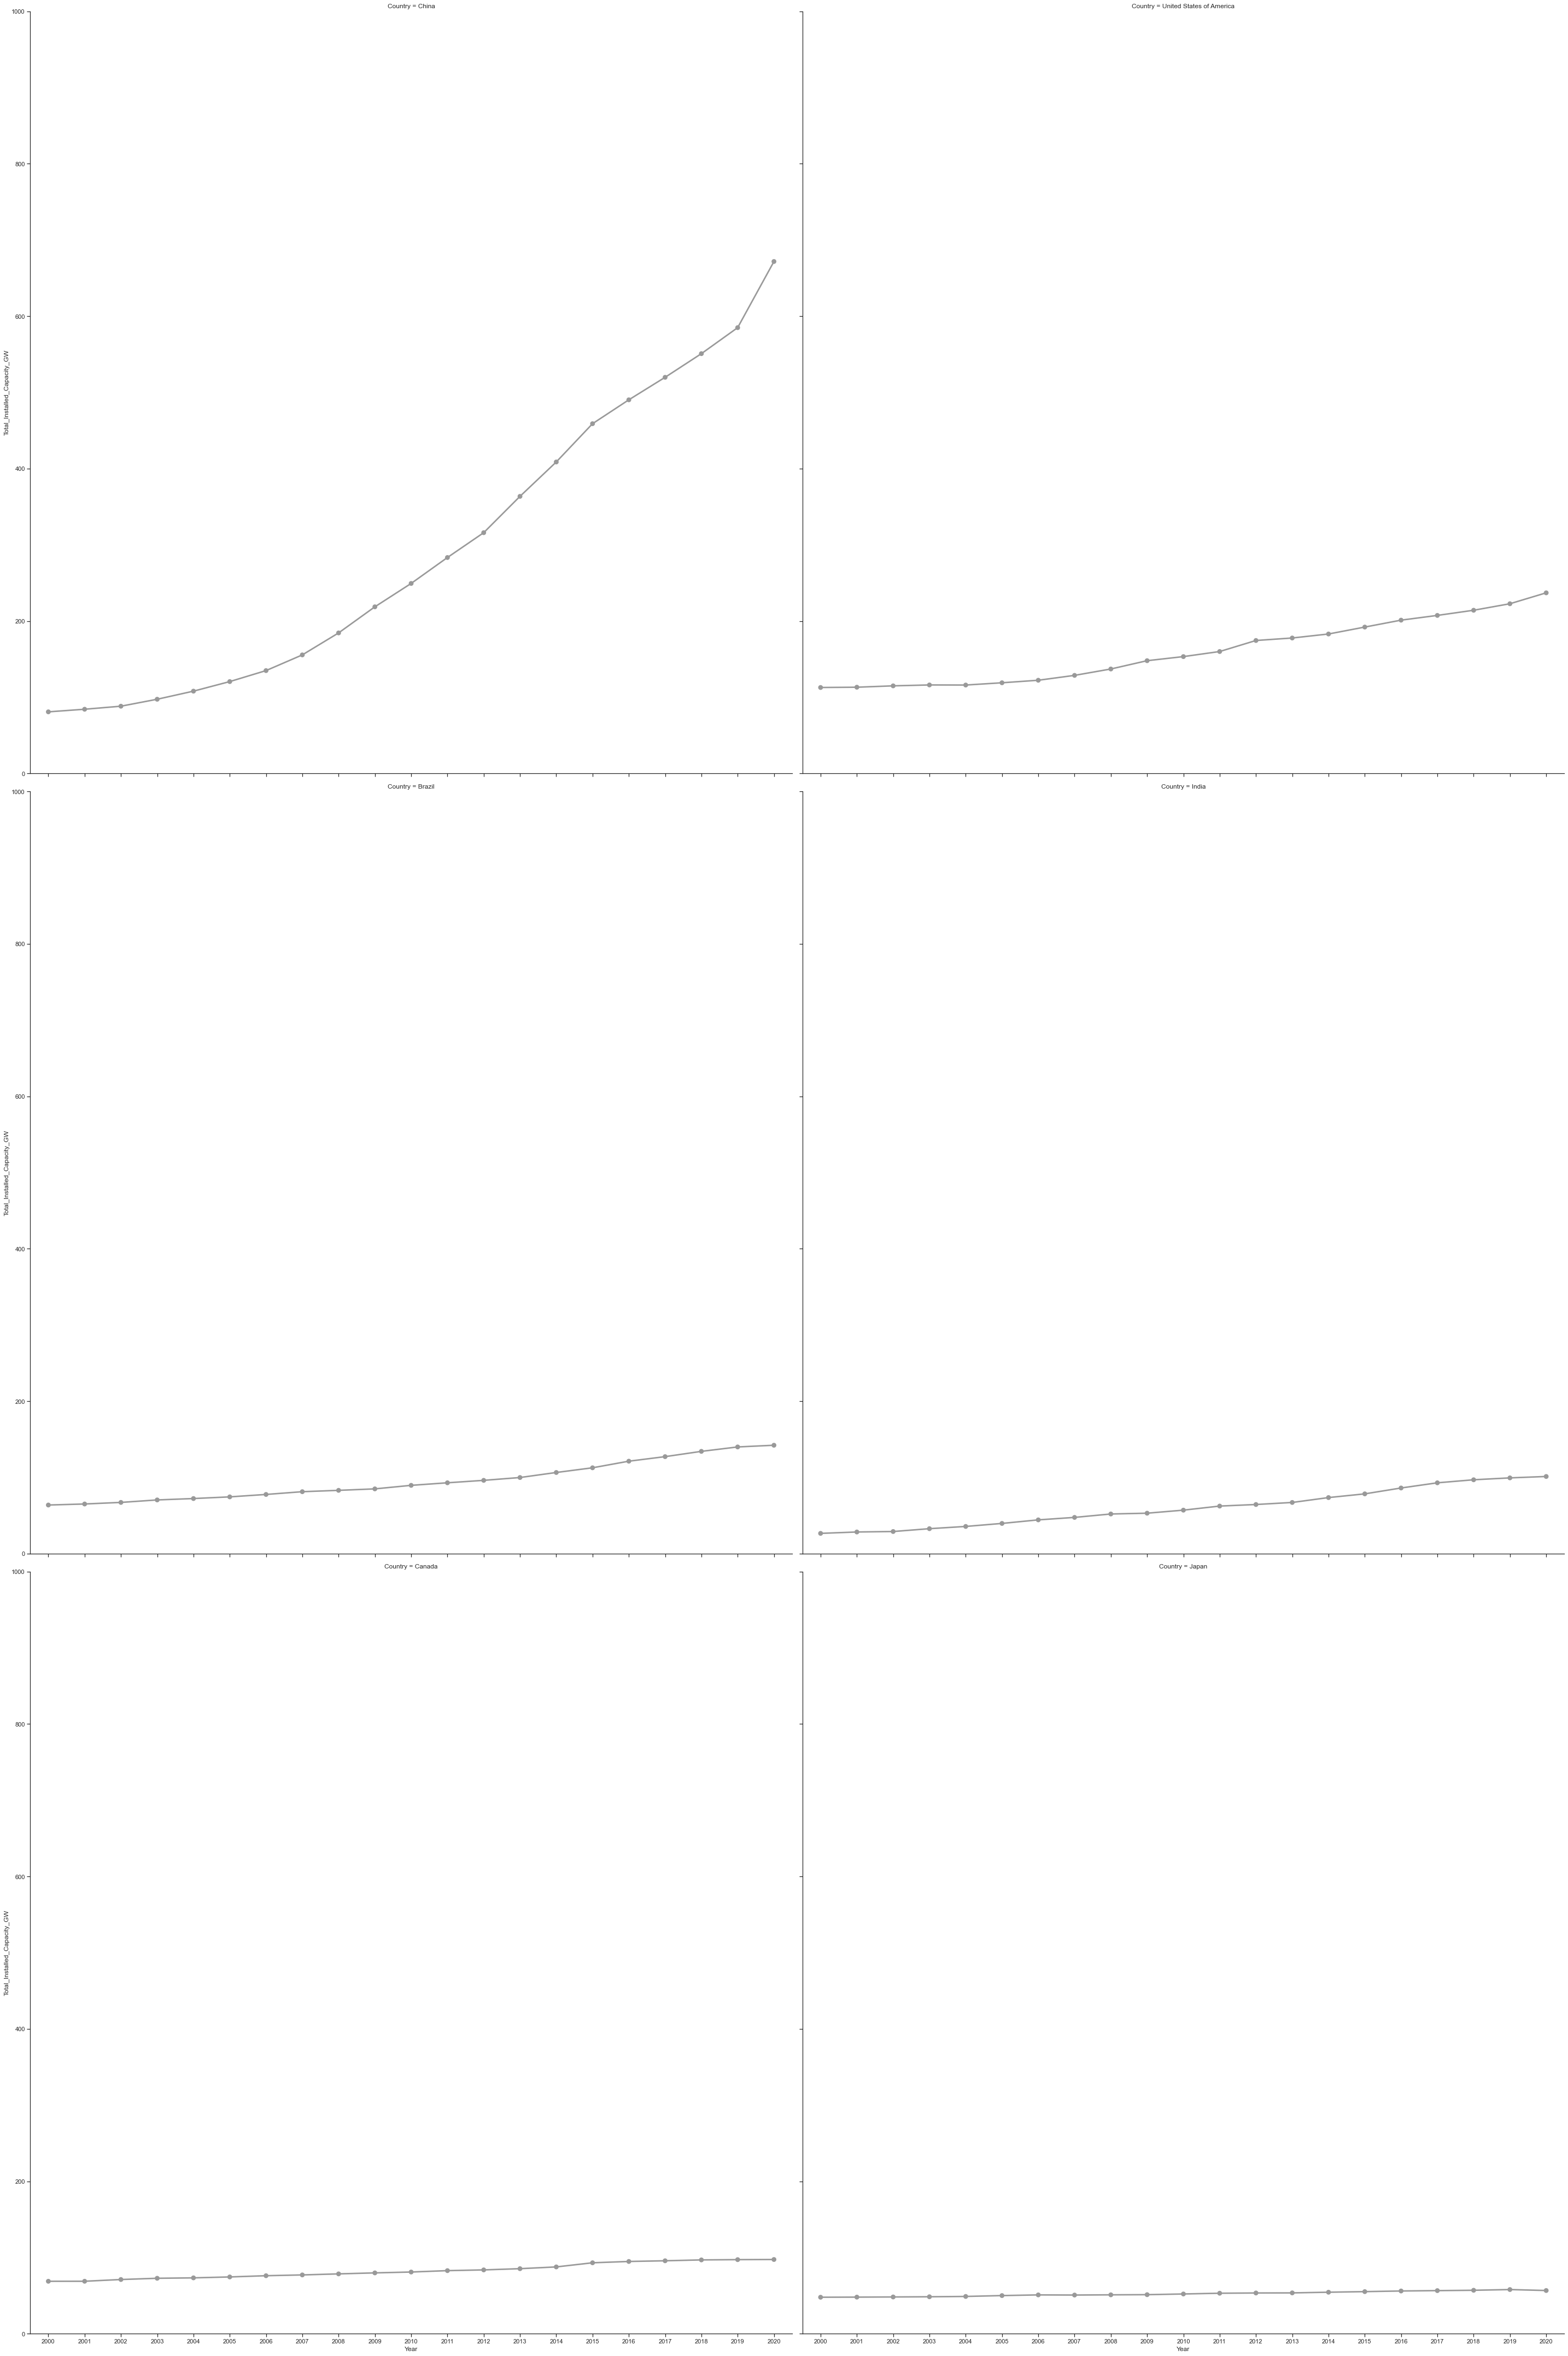

In [10]:
totalTopCountryInstCapRenew_PandaDF = totalTopInstCapRenew_PandaDF[(totalTopInstCapRenew_PandaDF['Country'].isin(['China','United States of America','Japan','Brazil','India','Canada']))].reset_index()
yearList = totalTopCountryInstCapRenew_PandaDF['Year'].unique()
sns.set_theme(style="ticks")
g = sns.FacetGrid(totalTopCountryInstCapRenew_PandaDF, col="Country", col_wrap=2, height=20, ylim=(0, 1000))
g.map(sns.pointplot, "Year", "Total_Installed_Capacity_GW", order=np.sort(yearList), color=".6", ci=None)

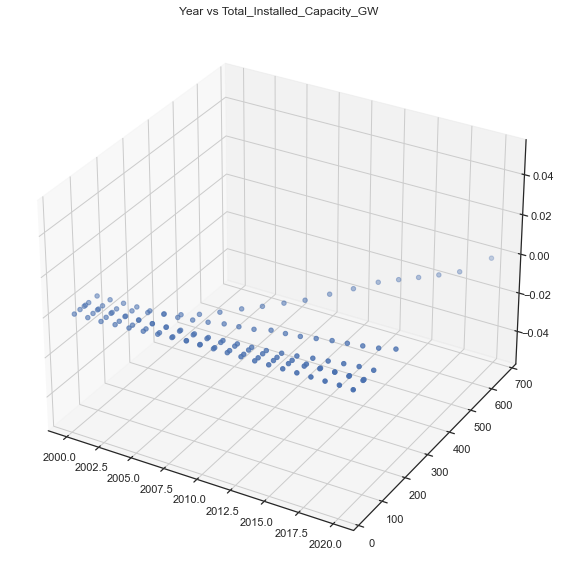

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(totalTopCountryInstCapRenew_PandaDF['Year'],totalTopCountryInstCapRenew_PandaDF['Total_Installed_Capacity_GW'])
ax.set_title("Year vs Total_Installed_Capacity_GW")
plt.show()

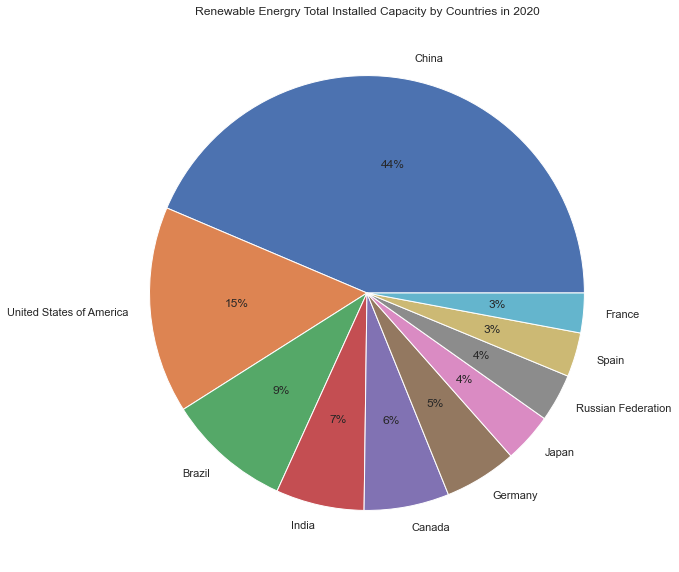

In [12]:
import matplotlib.pyplot as plt
totalTopInstCapRenew20_PandaDF = totalTopInstCapRenew_PandaDF.query('Year == 2020')
plt.pie(totalTopInstCapRenew20_PandaDF["Total_Installed_Capacity_GW"], 
        labels=totalTopInstCapRenew20_PandaDF["Country"], autopct='%1.0f%%')
plt.title("Renewable Energry Total Installed Capacity by Countries in 2020")
plt.show()

In [13]:
worldTotalInstCapRenew_PandaDF = totalTopInstCapRenew_PandaDF.groupby('Year')['Total_Installed_Capacity_GW'].agg('sum').reset_index()
worldTotalInstCapRenew_PandaDF

Year  Total_Installed_Capacity_GW
0   2000                   522.454569
1   2001                   530.006620
2   2002                   542.874900
3   2003                   564.792401
4   2004                   585.394374
5   2005                   615.454243
6   2006                   648.937089
7   2007                   689.830492
8   2008                   738.599653
9   2009                   797.016188
10  2010                   849.344027
11  2011                   906.936811
12  2012                   967.824902
13  2013                  1032.475589
14  2014                  1106.438579
15  2015                  1191.357407
16  2016                  1257.264963
17  2017                  1315.990626
18  2018                  1371.834306
19  2019                  1431.093911
20  2020                  1540.527743

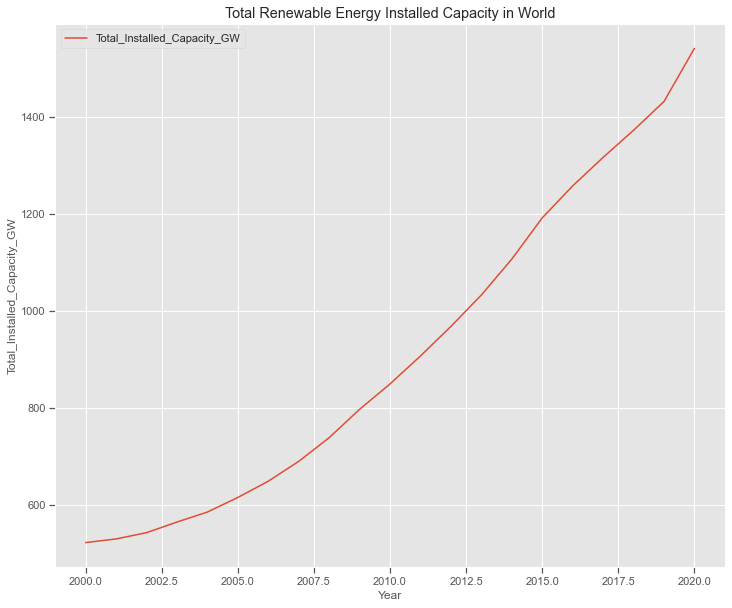

In [14]:
#matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(12, 10))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

worldTotalInstCapRenew_PandaDF.plot(title = 'Total Renewable Energy Installed Capacity in World',x ='Year', y='Total_Installed_Capacity_GW' ,xlabel = 'Year', ylabel = 'Total_Installed_Capacity_GW')
plt.legend(loc=2)